# Unsupervised Machine Learning Techniques I
Anderson Nelson  <br>
Date: 10/20/2019 <br>

### Introduction: 

In the last assignment, I reduced the number of variables based on a correlation threshold. My rationale for using the correlation as a threshold is that since the variables behave in a very similar manner, as far as the clustering algorithm is concerned, using one variable produces the same cluster as the other. If you clustered your data using two variables that were perfectly correlated, then you would get the same output, whether you used one or both variables. since the variables behave in the same way, the "distances" that k-means will use to cluster the data with respect to each variable will be identical.  The less correlated the variables are, however, will exert its own influence on these distances, and so influence the final clustering output.

What should that threshold be? That question is still unclear. If, for example, two variables have a 0.9 correlation, the ends clusters might be slightly different due to the 0.1 difference in the clusters. The variance in the end clusters is highly dependent on the data.  That assumption is one of the major drawbacks of using a correlation threshold, the risk of removing variables that explained some of the variances in the data. 

This week, I’m going to experiment using principal component analysis to analyze my features and select my variables and compare the results. Principle component, however, however, the interpretation of the variable isn’t as clear. PCA provides you with a magnitude of the variable impact and isn’t as clear. 



In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import MeanShift,estimate_bandwidth

import warnings
warnings.filterwarnings("error", message=".*check_inverse*.",
                        category=UserWarning, append=False)

In [2]:
# Read data 
data = pd.read_csv('Data/data.csv')
data = data.drop(columns = ['Unnamed: 0','Provider City','K Means 1'])

In [3]:
# Constant Names 
drg_defination_name ='DRG Definition'
provider_name = 'Provider Name'
prodiver_id_name = 'Provider Id'
proder_address_name = 'Provider Street Address'
provider_city_name = 'Provider City'
provider_state_name = 'Provider State'
provider_zip_code_name = 'Provider Zip Code'
hospital_referal_name = 'Hospital Referral Region Description'
total_discharges_name = 'Total Discharges'
average_covered_charges_name = 'Average Covered Charges'
average_total_payment_name = 'Average Total Payments'
average_medicare_payment = 'Average Medicare Payments'
region_name = 'Region'
division_name = 'Division'

Here I'm going to define a few functions that I'm going to use throughout the data

In [222]:
def normalized(data): 
    """Calculates the z score between two data sets"""
    mean = data.mean()
    sd = data.std()
    score = (data - mean) / sd
    return score 

def column_scaler(data): 
    """ 
    Scales each column in the dataset 
    """
    new_data = pd.DataFrame()
    for value in data.columns: 
        column_data = data[value]
        new_data[value] = normalized(column_data)
    return new_data
    
def correlation(dataset, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset

def PCA_Col_names(count):
    colname = []
    rowname = 1
    while rowname <= count: 
        colname.append(f'Principle Component {rowname}')
        rowname += 1 
    return (colname)

# consolidate outlier 
def consolodate_outliers(labels, threshold): 
    new_labels = []
    for i in labels: 
        if i == threshold: 
            new_labels.append('Normal')
        else: 
            new_labels.append('Outlier')

    count = np.unique(new_labels, return_counts=True)
    return new_labels,pd.DataFrame(count)

In [5]:
data_subset = data.iloc[:,7:]
data_subset_name = data_subset.columns
data_subset.head()
data_subset_scaled = StandardScaler().fit_transform(data_subset)
data_subset_scaled = pd.DataFrame(data_subset_scaled, columns=data_subset_name)

model_data = correlation(data_subset_scaled, 0.5)
print(f' There are {len(model_data.columns)} columns remaining in the data')

 There are 11 columns remaining in the data



The PCA indicates that 91% of the variables can be explained by 7 principal components, and it scales to 99% at 10 variables. Earlier, we discussed how just 10% of the variance could impact the final clusters. In order to capture as much variance as I chose 10 variables. I could also choose 9, given that the additional principal component adds an incremental 2%. 


In [6]:
pca = PCA()
pca_fit = pca.fit_transform(data_subset_scaled)  

explained_ratio = pca.explained_variance_ratio_
explained_ratio = np.round(explained_ratio, 2)
np.cumsum(explained_ratio)

array([0.2 , 0.39, 0.53, 0.64, 0.75, 0.83, 0.91, 0.95, 0.97, 0.99, 1.01])

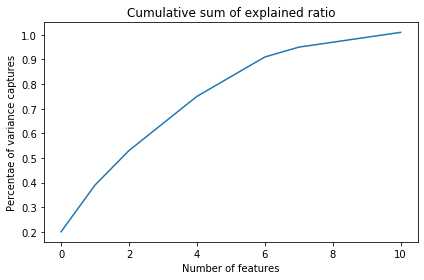

In [7]:
plt.plot(np.cumsum(explained_ratio))
plt.title('Cumulative sum of explained ratio')
plt.xlabel('Number of features')
plt.ylabel('Percentae of variance captures')
plt.tight_layout()
plt.show()

In [8]:
pca_col_names = PCA_Col_names(9)
pca = PCA(n_components=9)
pca_fit = pca.fit_transform(data_subset_scaled)
pca_dat = pd.DataFrame(pca_fit,columns=pca_col_names)

In [29]:
pca.whiten

False

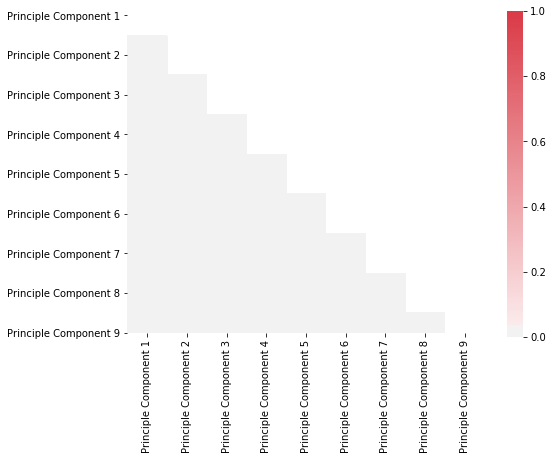

In [9]:
fig = plt.figure(figsize=(8,6))
corr = pca_dat.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and caorrect aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True)
plt.show()

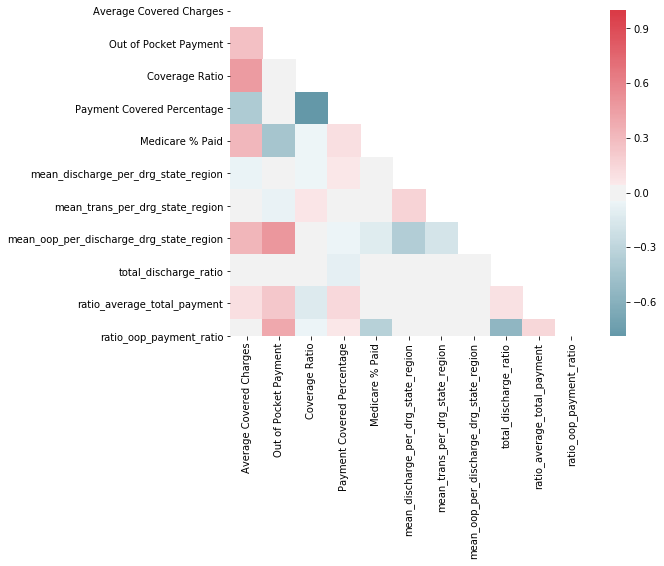

In [10]:
fig = plt.figure(figsize=(8,6))
corr = data_subset_scaled.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and caorrect aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True)
plt.show()

## DBSCAN

DBSCAN does a great job of seeking areas in the data that have a high density of observations, versus areas of the data that are not very dense with observations. It only takes two parameters, eps= How far away can one point be from the next point within the same cluster , min sample = the minimum number of data points needed to determine a single cluster. I tried a few different combinations of those parameters. 

I saw that DBSCAN groups together a large chunk of the variables together and create separate, and different clusters for all the varables that far from the main cluster. I grouped them together and called them my outliter clusters. 


#### PCA

In [11]:
# Compute DBSCAN
pca_db = DBSCAN(eps=0.3, min_samples=20).fit(pca_dat)
pca_db_labels = pca_db.labels_
len(set(pca_db_labels))

5

In [12]:
cluster, count = np.unique(pca_db_labels, return_counts=True)
dict(zip(cluster, count))

{-1: 162823, 0: 94, 1: 17, 2: 106, 3: 25}

In [13]:
# consolidate outlier 
new_labels = []
for i in pca_db_labels: 
    if i == -1: 
        new_labels.append('Normal')
    else: 
        new_labels.append('Outlier')

np.unique(new_labels, return_counts=True)        

(array(['Normal', 'Outlier'], dtype='<U7'),
 array([162823,    242], dtype=int64))

In [14]:
pca_dat['DB Scan Label'] = new_labels 

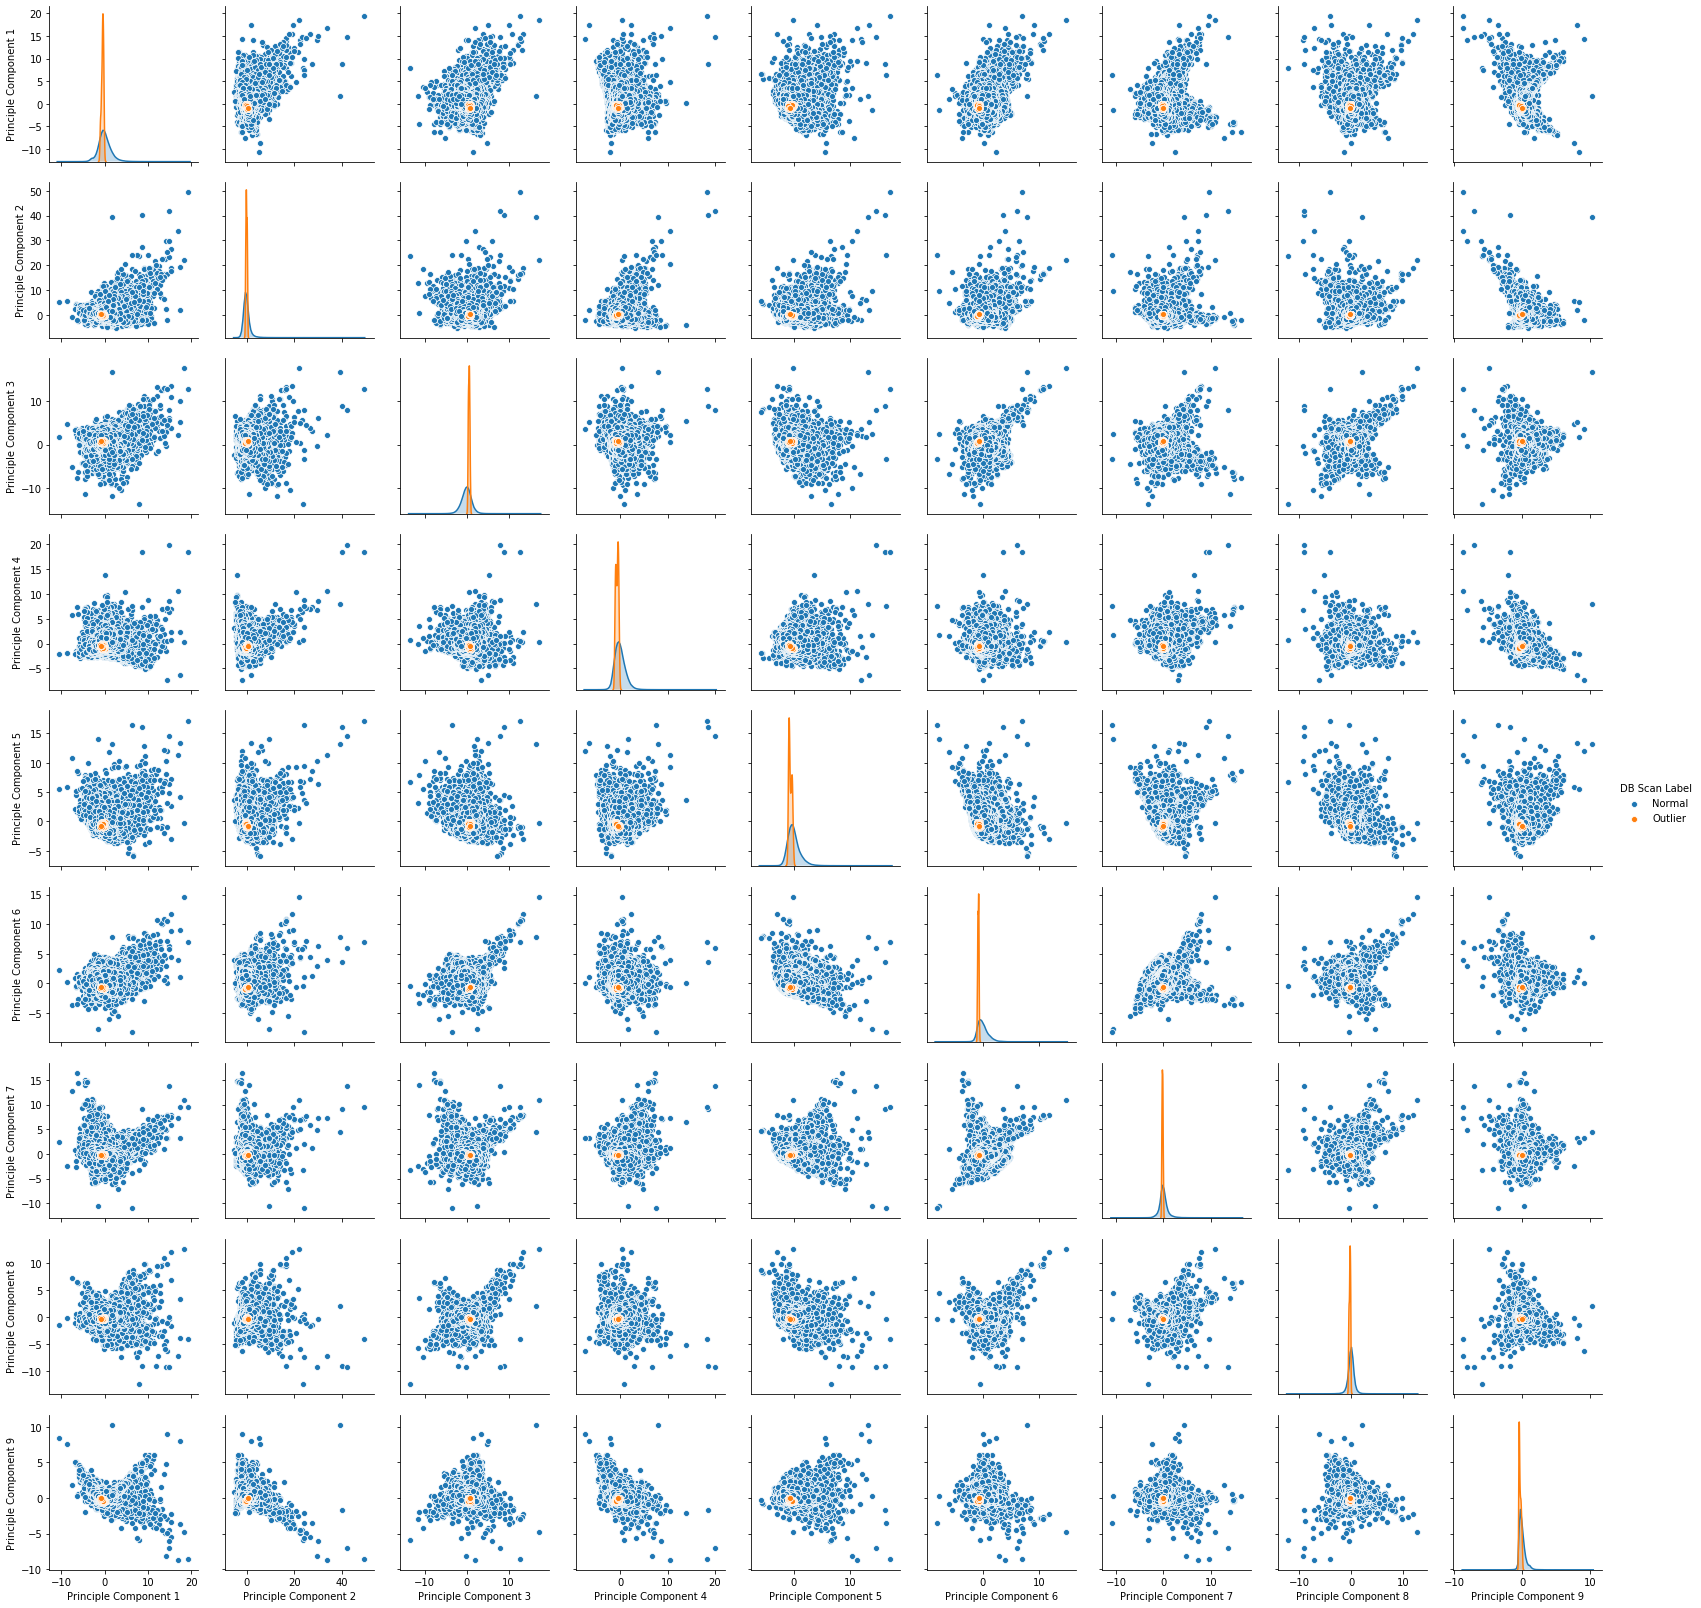

In [15]:
sns.pairplot(pca_dat, hue = 'DB Scan Label')

#### Correlation Data

In [17]:
# Compute DBSCAN on scaled data 
scaled_db = DBSCAN(eps=0.3, min_samples=20).fit(data_subset_scaled)
scaled_db_labels = sclaed_db.labels_
len(set(scaled_db_labels))

6

In [18]:
scaled_cluster, count = np.unique(scaled_db_labels, return_counts=True)
dict(zip(scaled_cluster, count))

{-1: 162888, 0: 45, 1: 18, 2: 78, 3: 18, 4: 18}

In [19]:
# consolidate outlier 
new_labels = []
for i in scaled_db_labels: 
    if i == -1: 
        new_labels.append('Normal')
    else: 
        new_labels.append('Outlier')

np.unique(new_labels, return_counts=True)        

(array(['Normal', 'Outlier'], dtype='<U7'),
 array([162888,    177], dtype=int64))

In [99]:
data_subset_scaled['DB Scan Label'] = new_labels 

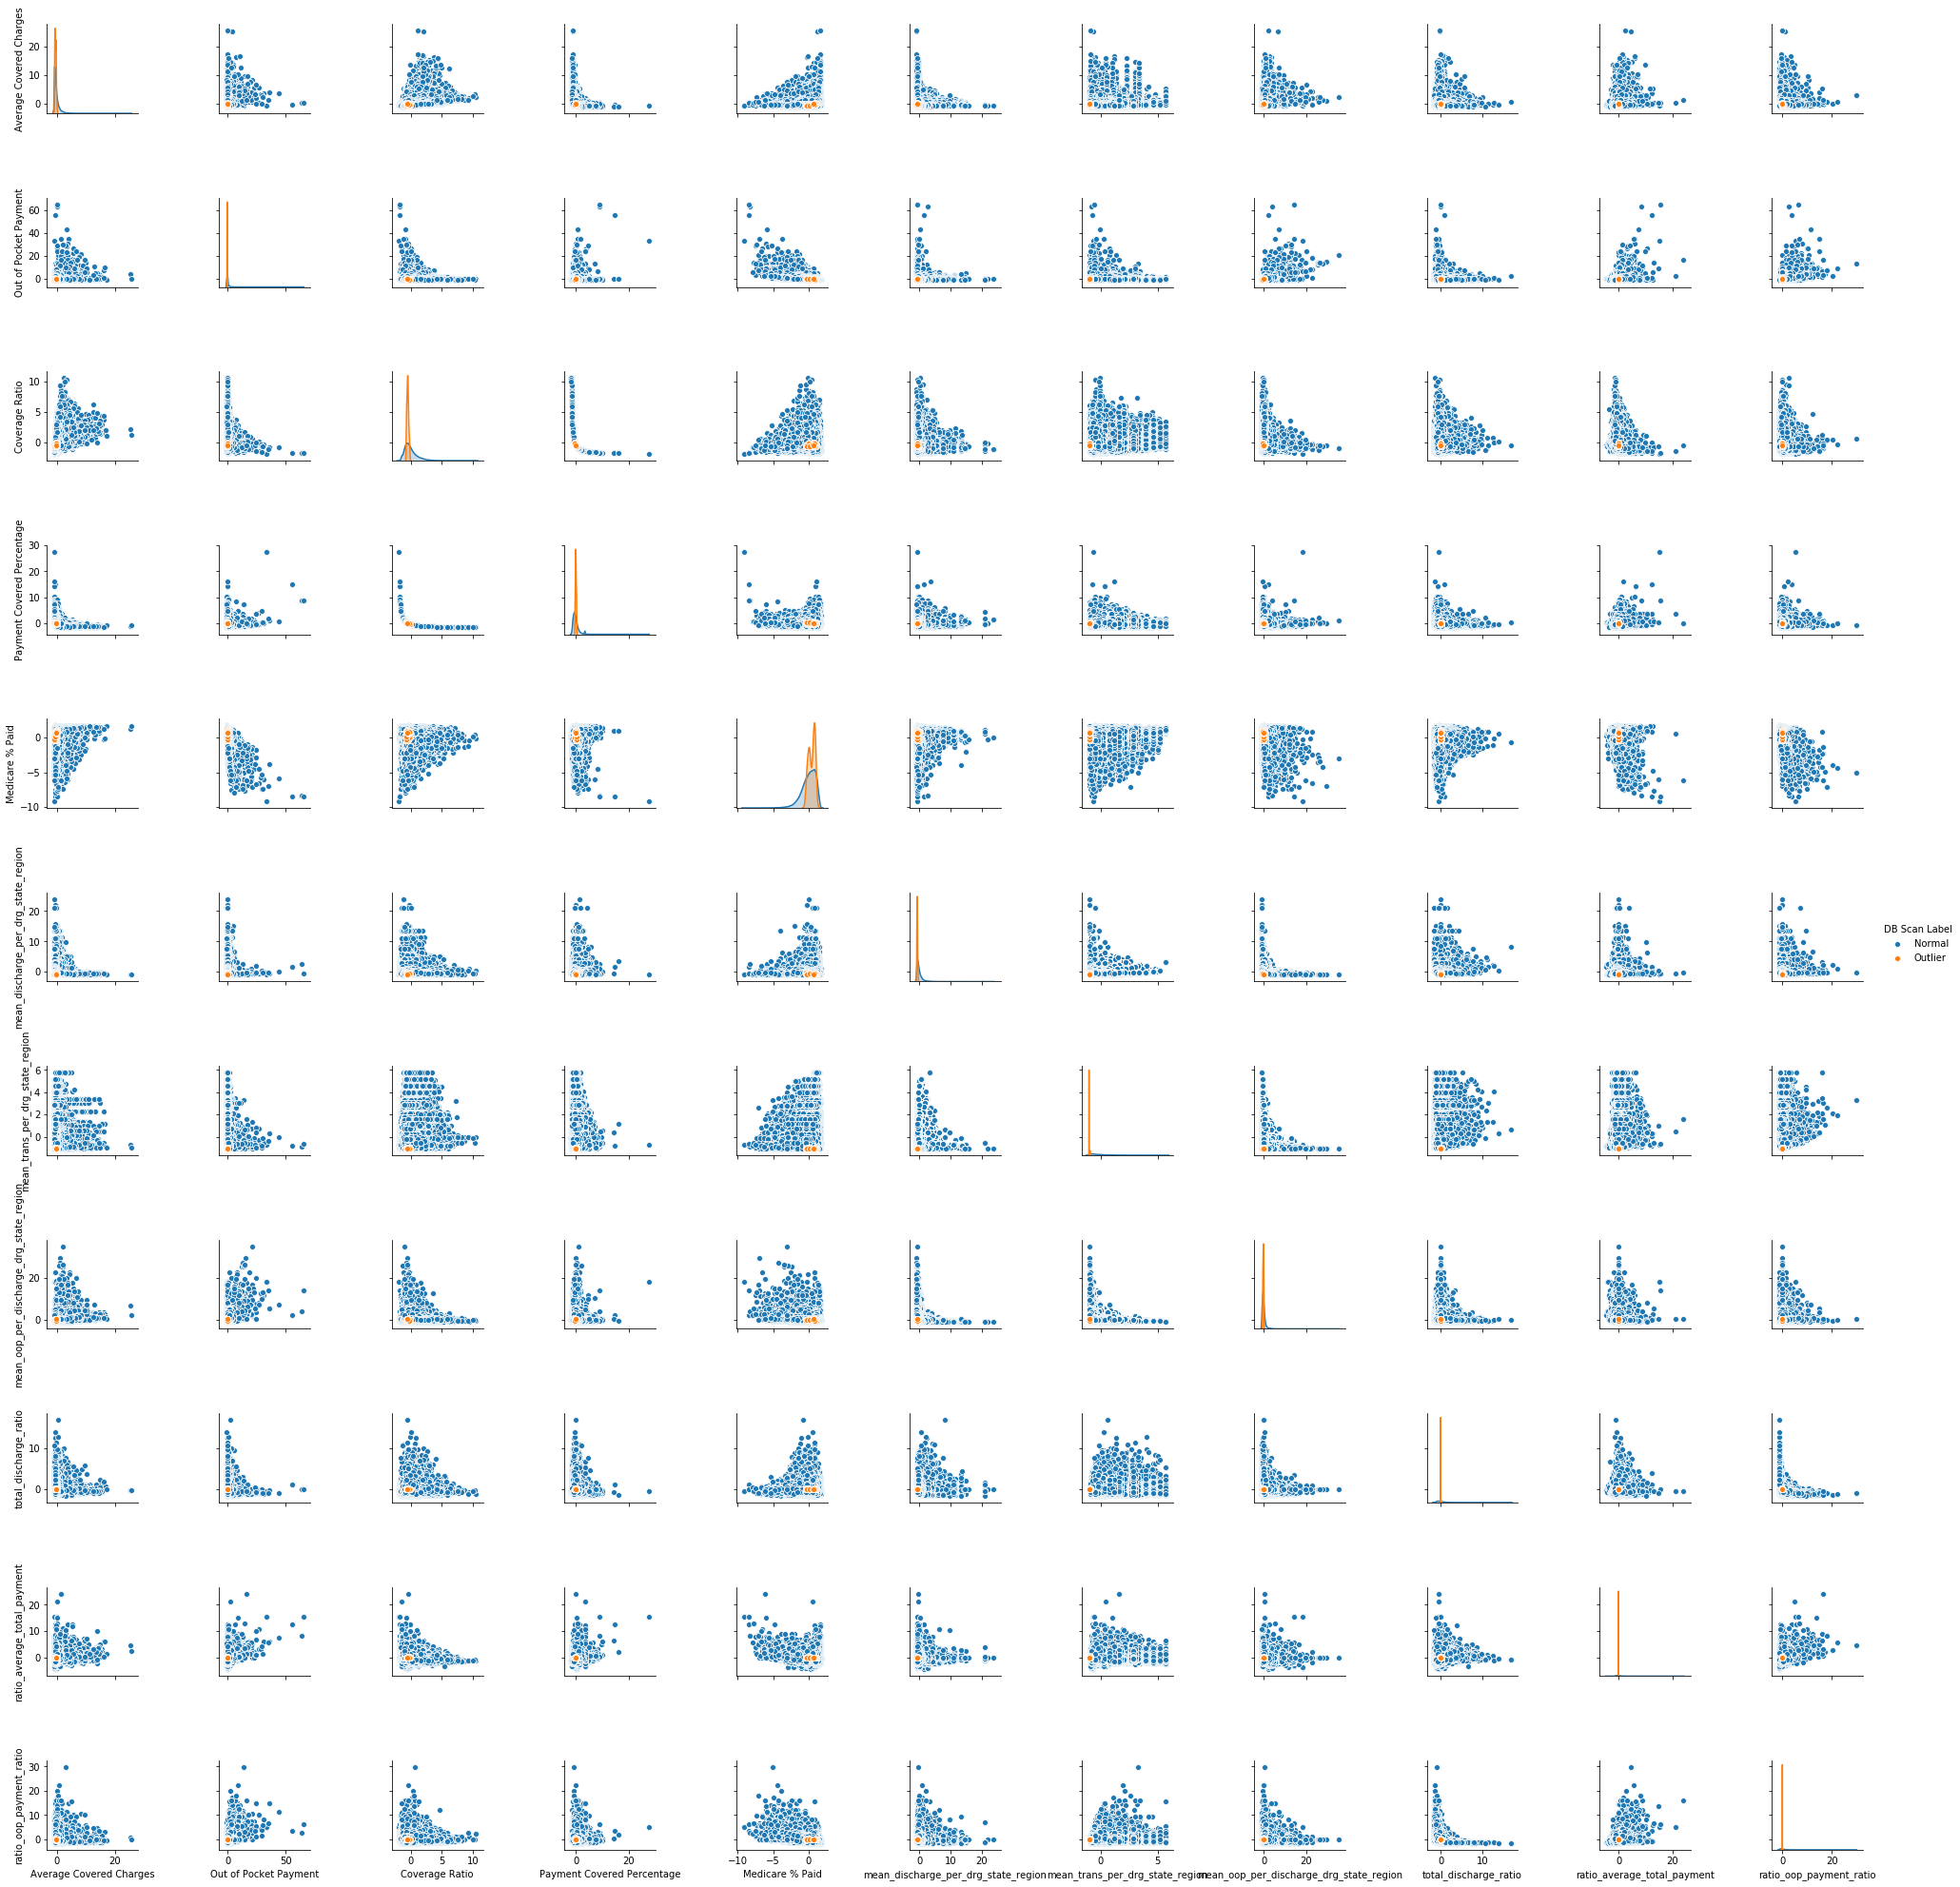

In [100]:
sns.pairplot(data_subset_scaled, hue = 'DB Scan Label')

I'm curious if the PCA and correlation identifed the same Providers 

In [34]:
indices_corr = data_subset_scaled['DB Scan Label'] == 'Outlier'
indices_pca = pca_dat['DB Scan Label'] == 'Outlier'

In [267]:
corr_outlier = data[indices_corr]['Provider Name']
pca_outlier = data[indices_pca]['Provider Name']

print(f'The outliers identified using the correlation analysis contains {len(pd.unique(corr_outlier))}  unique providers' )
print(f'The outliers identified using the PCA analysis contains {len(pd.unique(pca_outlier))} unique provider' )

corr_outlier=pd.DataFrame(pd.unique(corr_outlier))
pca_outlier=pd.DataFrame(pd.unique(pca_outlier))

The outliers identified using the correlation analysis contains 97  unique providers
The outliers identified using the PCA analysis contains 122 unique provider


In [96]:
len(pd.merge(corr_outlier, pca_outlier,on =0))

97

The principle component analysis identified the same Provider names in the correlation, and it included more 25 more variables. Lets view what those variables look like 

Now that I see what the outliers are, I'm not too convinced that they really are outliers. There are some instances where it makes sense, for example low average payment and low out of pocket payments and higher percentage medicare paid.

The rest of the plots point to seem to be located in the middle of the scatter plots. 

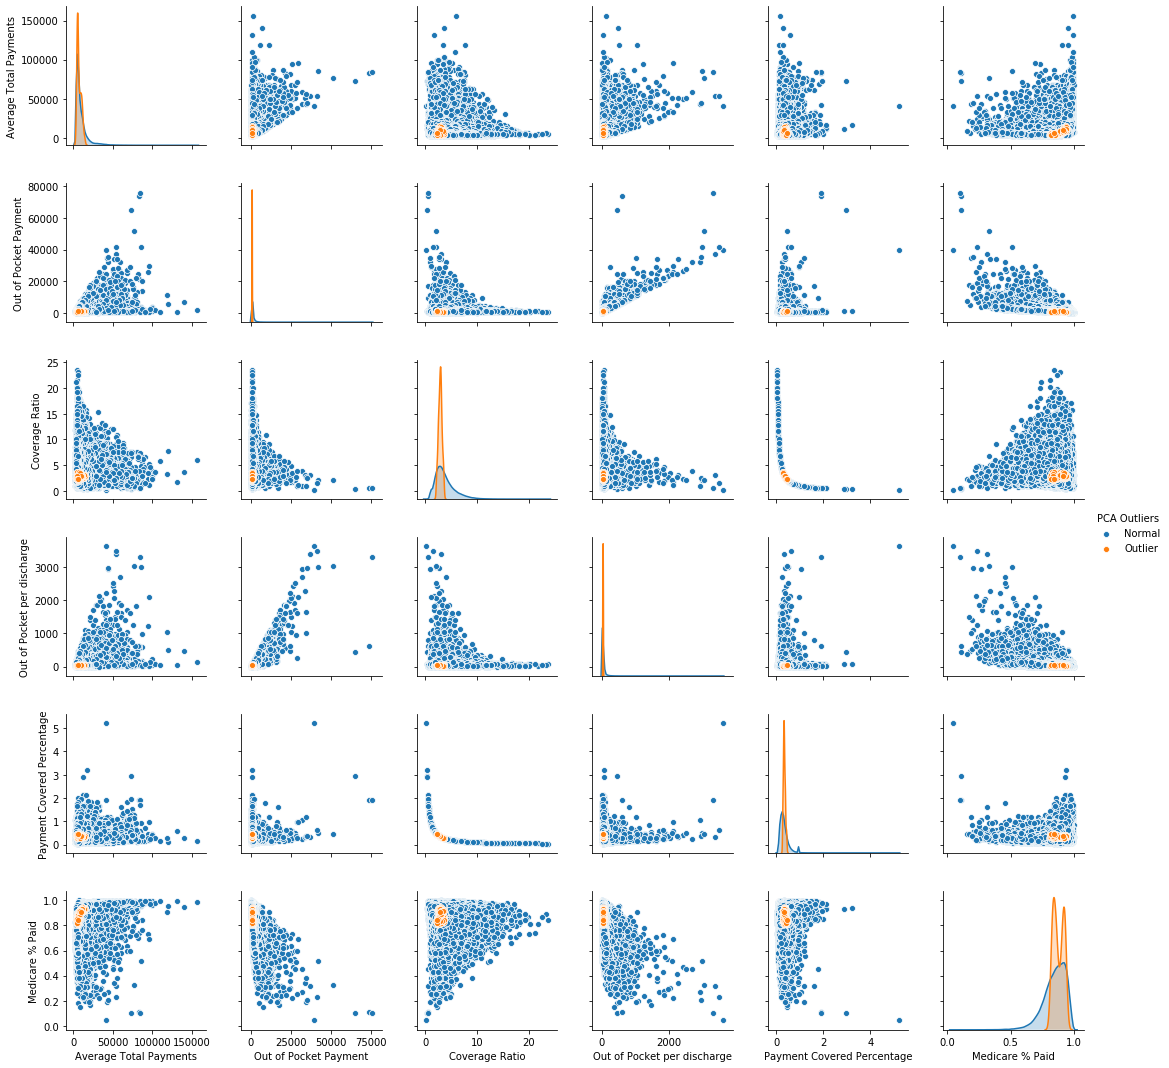

In [136]:
data_subset['PCA Outliers'] = pca_dat['DB Scan Label']
sns.pairplot(data_subset.iloc[:,[1,3,4,5,6,7,28]], hue = 'PCA Outliers')

### Mean Shift 
Since we the dataset contains number observations, the mean shift algorithm took a long time to run, I took a subset, and calculated the clusters based on that subset. Similar to the DBSCAN algorithm, the mean shift naturally tends to create 1 cluster if the min cluster size if greater than 15.  I’m interpreting this as the variation in the data is small and difficult to isolate, hence the reason for creating multiple clusters. 


In [226]:
data_subset_MS = data_subset[1:30000]

#### PCA

The PCA approach produced 26 unique clusters, many of which have 1 value.The outlier clusters are scatterred around the main clusters, indicating that there's no dominant pattern observed for the outliers. When graphed in the original data, the outliers blended in, and no unique pattern emerged.  

In [ ]:
pca_dat = pca_dat.drop(columns='DB Scan Label')

In [214]:
pca_data_subset = pca_dat[1:30000]

In [215]:
bandwith = estimate_bandwidth(pca_data_subset)
ms = MeanShift(bandwidth=bandwith, bin_seeding=True)
ms.fit_predict(pca_data_subset)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [216]:
# The following bandwidth can be automatically detected using
ms_labels_pca = ms.labels_
ms_pca_cluster_centers = ms.cluster_centers_

ms_pca_labels_unique = np.unique(ms_labels_pca)
ms_pca_n_clusters_ = len(ms_pca_labels_unique)

print("number of estimated clusters : %d" % ms_pca_n_clusters_)

number of estimated clusters : 26


In [217]:
# how many observations in each cluster
cluster, count = np.unique(ms_labels_pca, return_counts=True)
dict(zip(cluster, count))

{0: 29692,
 1: 32,
 2: 23,
 3: 5,
 4: 9,
 5: 13,
 6: 26,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 13,
 14: 1,
 15: 1,
 16: 135,
 17: 9,
 18: 2,
 19: 1,
 20: 1,
 21: 2,
 22: 13,
 23: 1,
 24: 12,
 25: 2}

<Figure size 432x288 with 0 Axes>

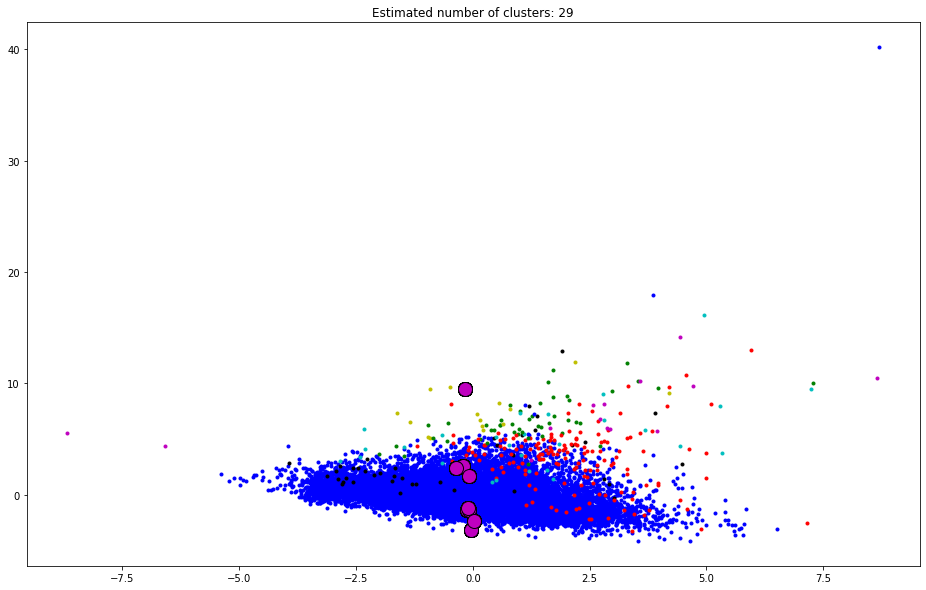

In [218]:
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(16,10))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(ms_pca_n_clusters_), colors):
    my_members = ms_labels_pca == k
    cluster_center = ms_pca_cluster_centers[k]
    plt.plot(pca_data_subset.iloc[my_members, 0], pca_data_subset.iloc[my_members, 1], col + '.')
    plt.plot(ms_pca_cluster_centers[0], ms_pca_cluster_centers[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [223]:
pca_label, count = consolodate_outliers(ms_labels_pca, 0)
count

,0,1
0,Normal,Outlier
1,29692,307


In [227]:
data_subset_MS['MS label PCA'] = pca_label

C:\Users\ander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [229]:
data_subset_MS = data_subset_MS.drop(columns=['Corr labels', 'PCA Outliers'])

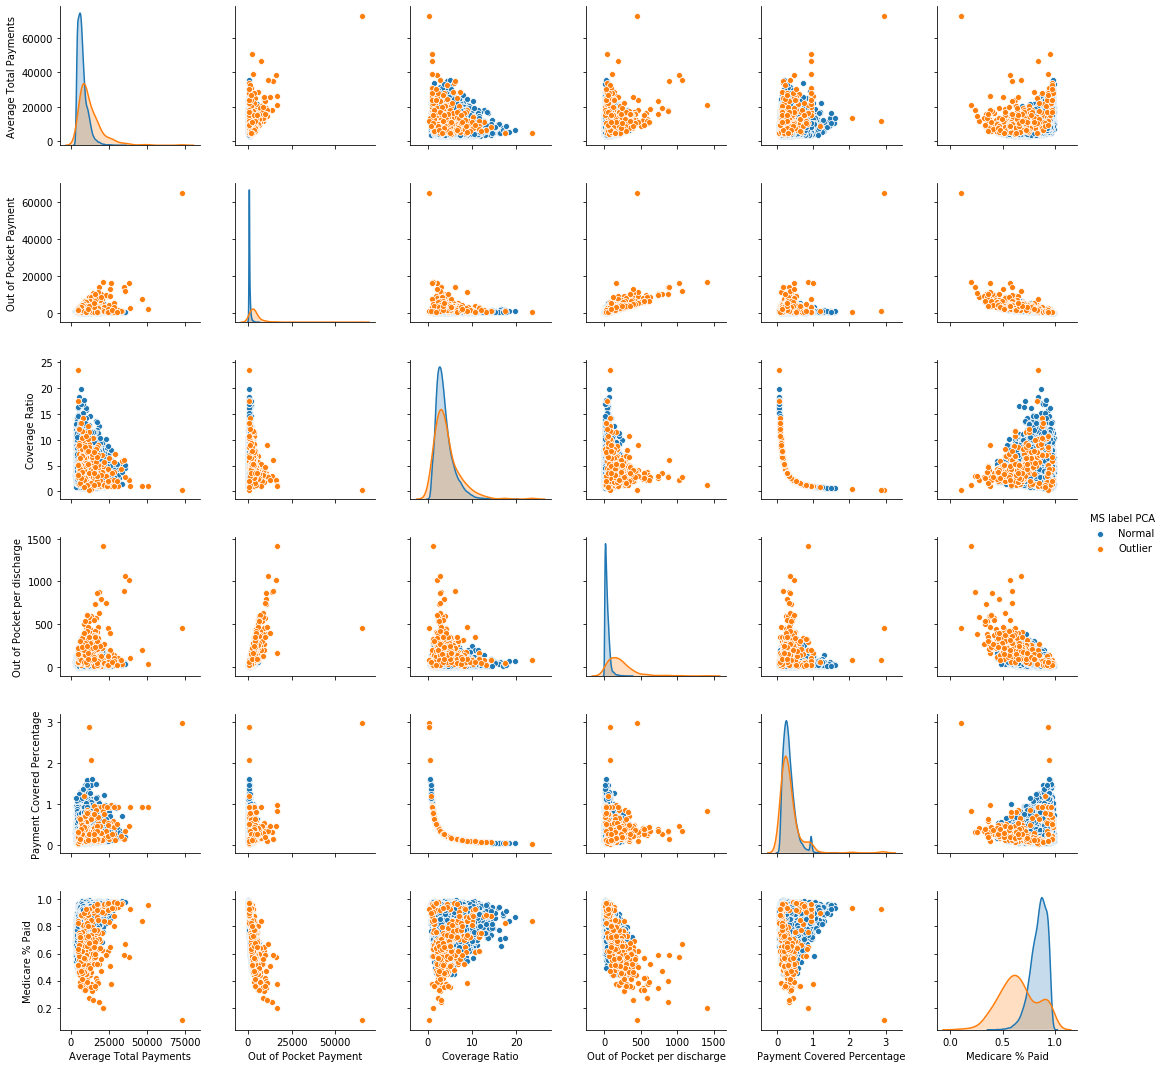

In [233]:
sns.pairplot(data_subset_MS.iloc[:,[1,3,4,5,6,7,27]], hue = 'MS label PCA')

In [ ]:
data_subset_scaled= data_subset_scaled.drop(columns='DB Scan Label')

Correlation

The correlation data set produced similar results as the PCA dataset. No significant pattern can be observed. 

In [242]:
data_subset_MS = data_subset_MS.drop(columns = 'MS label PCA')

In [238]:
corr_data_subset = data_subset_scaled[1:30000]
corr_bandwith = estimate_bandwidth(corr_data_subset)
corr_ms = MeanShift(bandwidth=corr_bandwith, bin_seeding=True)
corr_ms.fit_predict(corr_data_subset)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [239]:
# The following bandwidth can be automatically detected using
corr_labels = corr_ms.labels_
corr_cluster_centers = ms.cluster_centers_

corr_labels_unique = np.unique(corr_labels)
corr_n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# how many observations in each cluster
cluster, count = np.unique(ms.labels_, return_counts=True)
dict(zip(cluster, count))

number of estimated clusters : 29


{0: 29509,
 1: 34,
 2: 14,
 3: 9,
 4: 45,
 5: 2,
 6: 23,
 7: 2,
 8: 1,
 9: 1,
 10: 71,
 11: 28,
 12: 7,
 13: 1,
 14: 1,
 15: 2,
 16: 124,
 17: 1,
 18: 2,
 19: 1,
 20: 52,
 21: 2,
 22: 5,
 23: 2,
 24: 1,
 25: 1,
 26: 36,
 27: 3,
 28: 2,
 29: 16,
 30: 1}

<Figure size 432x288 with 0 Axes>

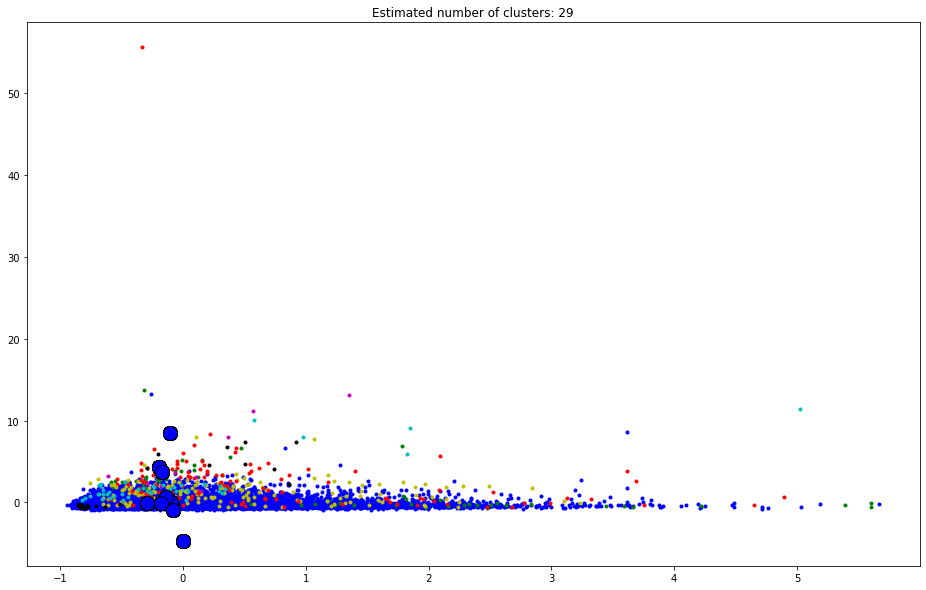

In [247]:
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(16,10))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(corr_n_clusters_), colors):
    my_members = corr_labels == k
    cluster_center = corr_cluster_centers[k]
    plt.plot(corr_data_subset.iloc[my_members, 0], corr_data_subset.iloc[my_members, 1], col + '.')
    plt.plot(corr_cluster_centers[0], corr_cluster_centers[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % corr_n_clusters_)
plt.show()

In [240]:
corr_label, count = consolodate_outliers(corr_labels, 0)
count

,0,1
0,Normal,Outlier
1,29582,417


In [243]:
data_subset_MS['MS label Corr'] = corr_label

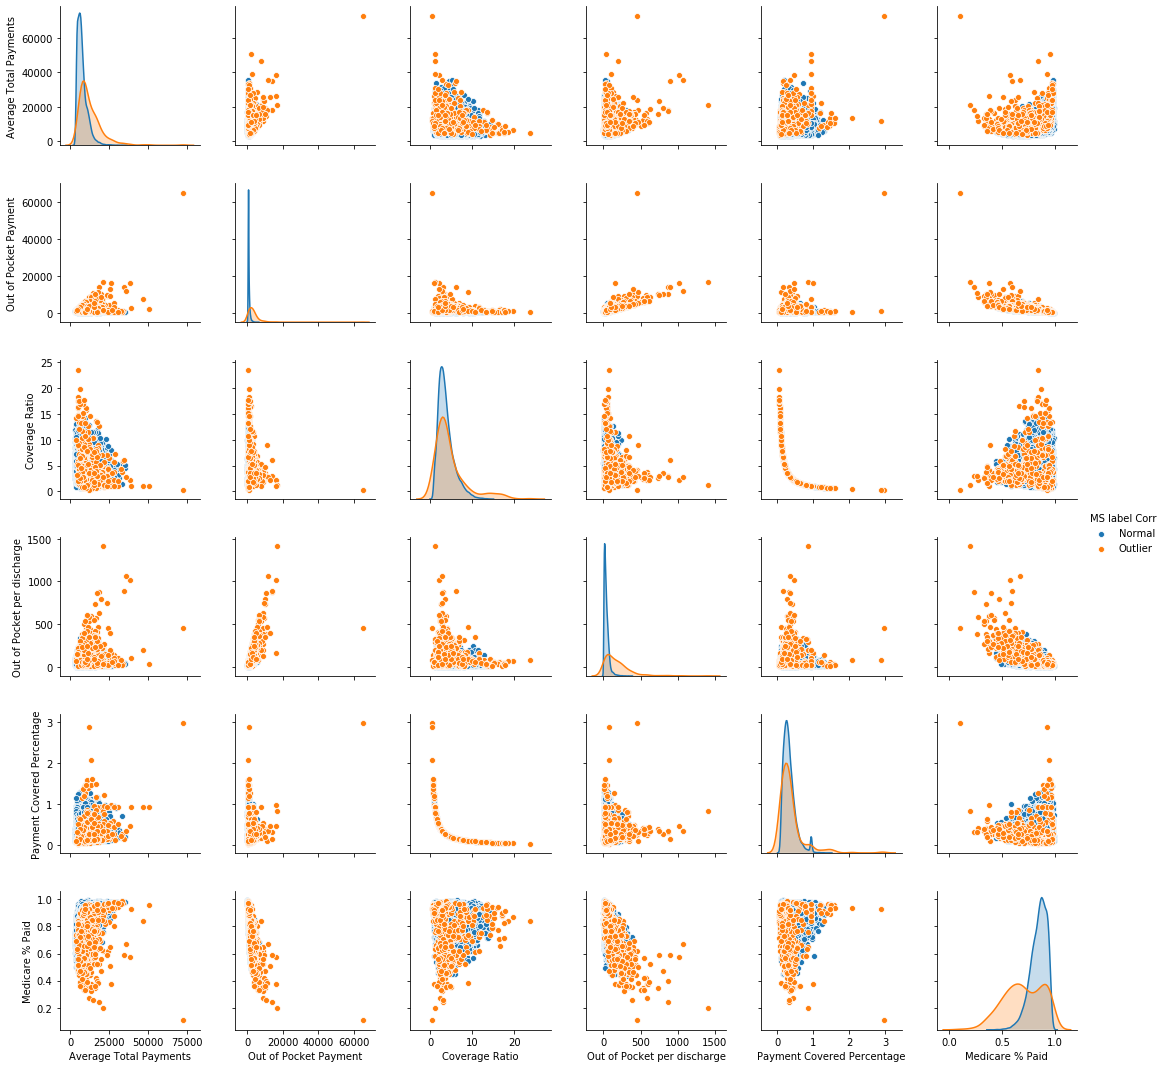

In [246]:
sns.pairplot(data_subset_MS.iloc[:,[1,3,4,5,6,7,27]], hue = 'MS label Corr')

In [255]:
corr_data_subset['MS label'] = corr_label
pca_data_subset['MS label'] = pca_label

C:\Users\ander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [259]:
ms_indices_corr = corr_data_subset['MS label'] == 'Outlier'
ms_indices_pca = pca_data_subset['MS label'] == 'Outlier'

In [265]:
data_subset_MS = data[1:30000]

ms_corr_outlier = data_subset_MS[ms_indices_corr]['Provider Name']
ms_pca_outlier = data_subset_MS[ms_indices_pca]['Provider Name']

print(f'The outliers identified using the correlation analysis contains {len(pd.unique(ms_corr_outlier))}  unique providers' )
print(f'The outliers identified using the PCA contains {len(pd.unique(ms_pca_outlier))} unique provider' )

ms_corr_outlier=pd.DataFrame(pd.unique(ms_corr_outlier))
ms_pca_outlier=pd.DataFrame(pd.unique(ms_pca_outlier))

The outliers identified using the correlation analysis contains 273  unique providers
The outliers identified using the PCA contains 228 unique provider


In [266]:
len(pd.merge(ms_corr_outlier, ms_pca_outlier,on =0))

225

The PCA parameters were determined using the entire data set . There are a few possible explanations for PCA capturing less than the correlation. The primary  explanation is that the PCA cal determined based on a larger data set, and the subset of the subset of the data created doesn’t capture the variance in the truncated dataset. 

A possible fix is to redo the PCA using the truncated dataset. 


### Conclusion: 

I’ve isolated anomalies using both DBSCAN and the Mean Shift Algorithm. This assignment helped me broaden my understanding of different unsupervised learning algorithms and identified the limitations of the K-means algorithm.  I now understand the circumstances to apply DBSCAN, Mean Shift, and K means. I also understand the impact of PCA and when to use it.  